In [92]:
import cv2
import math
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

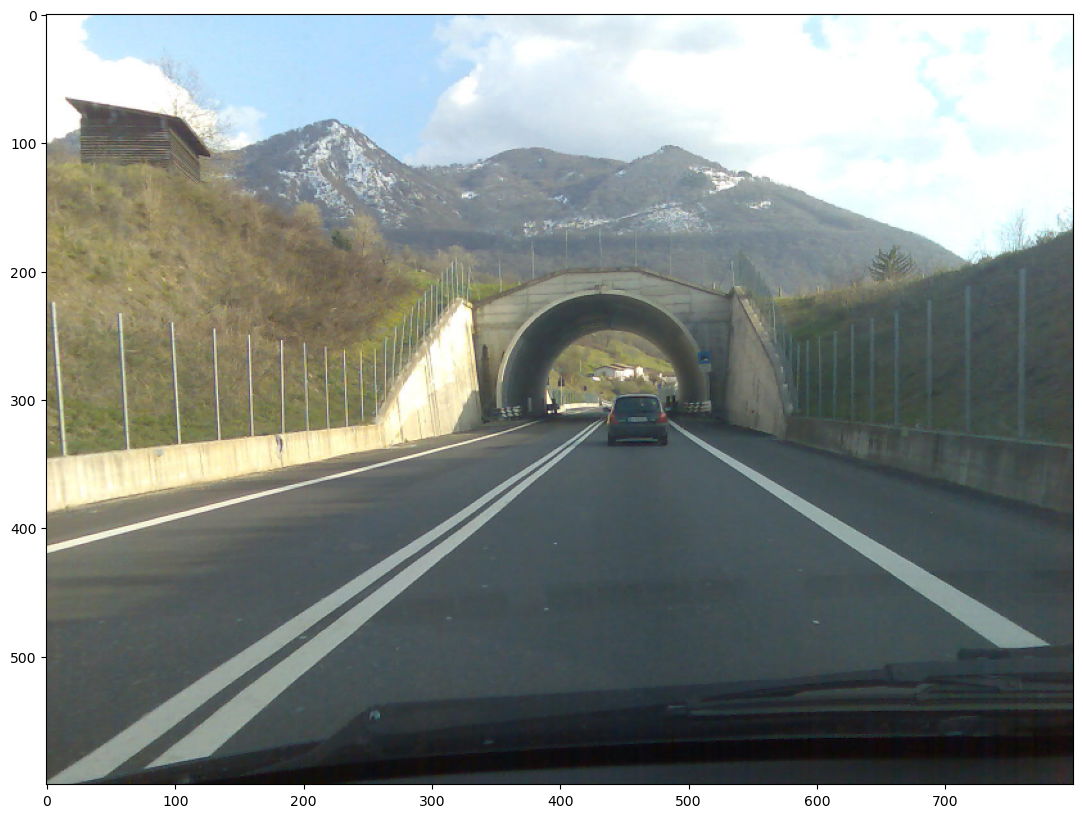

In [98]:
img = cv2.imread('dashcam.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, None, fx=0.5, fy=0.5)
plt.imshow(img)

In [107]:
# Convert image to gray scale
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

In [108]:
# Obtain edge map
# Hint: you can use Canny edge detector with th_low = 100, th_high = 150
edges = cv2.Canny(gray, 100, 150)

# We are only interseted in the road so we will remove everything above the horizon
edges[0:350] = 0

(<Axes: title={'center': 'Edge map'}>,
 Text(0.5, 1.0, 'Edge map'))

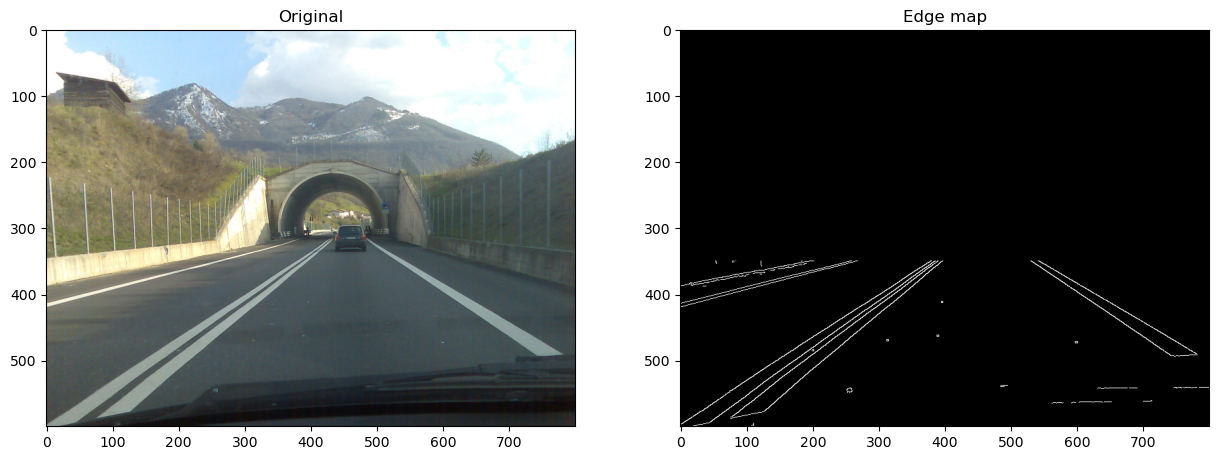

In [109]:
# Let's plot the images
plt.subplot(121), plt.imshow(img), plt.title('Original')
plt.subplot(122), plt.imshow(edges, cmap='gray'), plt.title('Edge map')

In [110]:
# Apply Hough transform to parametrize the lines
# Hint 1: Offset resolution of 2 pixels and slope resolution of 2 degrees work well in this case
# Hint 2: A suitable value for the accumulator threshold is 190
lines = cv2.HoughLines(edges, rho=2, theta=np.pi/180*2, threshold=190)

# Let's get rid of the unnecessary dimension
lines = lines[:, 0, :]

(<Axes: title={'center': 'Hough lines'}>,
 Text(0.5, 1.0, 'Hough lines'))

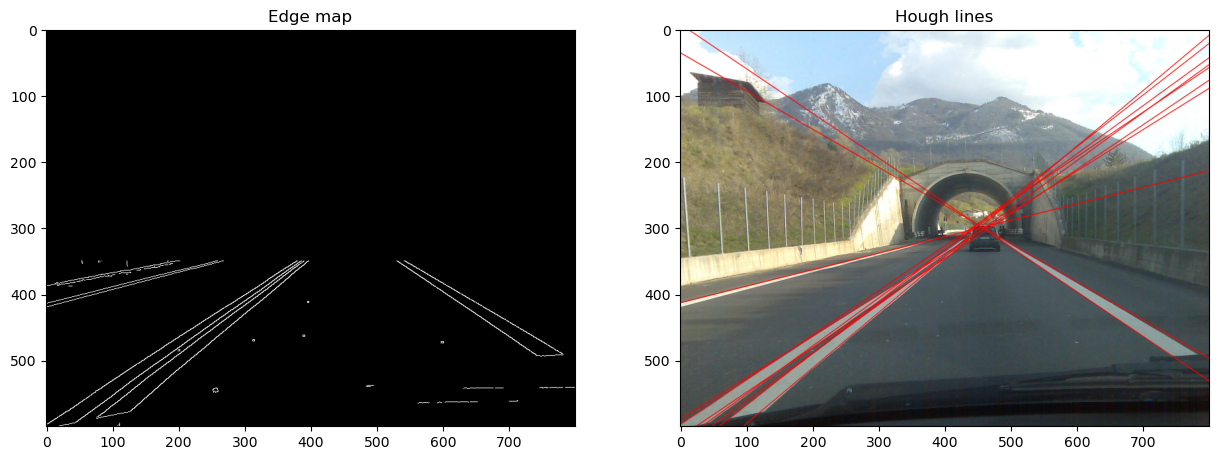

In [111]:
# Plot the resulting Hough lines
result = np.copy(img)
        
for line in lines:
    rho, theta = line
    
    a = math.cos(theta)
    b = math.sin(theta)
    
    x0 = a * rho
    y0 = b * rho
    
    pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
    pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
    
    cv2.line(result, pt1, pt2, 255, 1, cv2.LINE_AA)

plt.subplot(121), plt.imshow(edges, cmap='gray'), plt.title('Edge map')
plt.subplot(122), plt.imshow(result, cmap='gray'), plt.title('Hough lines')

In [112]:
# Filter out all lines that are approximately horizontal (+/- 20 degrees). 
filtered_lines = []

for line in lines:
    rho, theta = line
    
    # Convert theta to degrees
    theta_deg = np.degrees(theta)
    
    # Keep line if theta is not horizontal
    if (theta_deg < 70 or theta_deg > 110) and (theta_deg < 250 or theta_deg > 290):
        filtered_lines.append(line)


Text(0.5, 1.0, 'Filtered Hough lines')

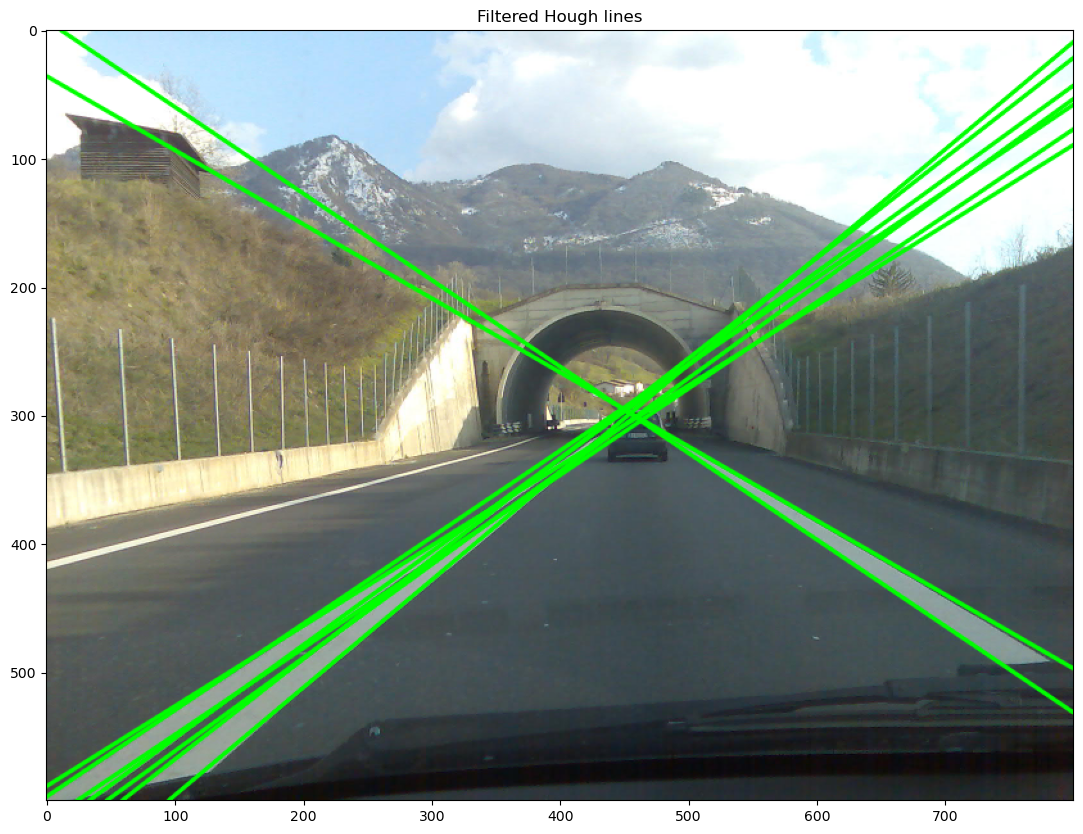

In [87]:
# Let's plot the resulting filtered lines
result_filtered = np.copy(img)

for line in filtered_lines:
    rho, theta = line
    
    a = math.cos(theta)
    b = math.sin(theta)
    
    x0 = a * rho
    y0 = b * rho
    
    pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
    pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
    
    cv2.line(result_filtered, pt1, pt2, (0, 255, 0), 2, cv2.LINE_AA)

plt.figure()
plt.imshow(result_filtered)
plt.title('Filtered Hough lines')

In [117]:
# We will apply k-means clustering to refine the detected lines.
# Don't worry, we will learn about the clustering later in the course :-)
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=6).fit(filtered_lines)
kmeans.cluster_centers_

C:\Users\dmale\anaconda3\envs\CV\Lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


array([[511.        ,   0.94247778],
       [ 31.        ,   2.09439516],
       [ -7.        ,   2.16420817],
       [497.        ,   0.99483767],
       [521.        ,   0.87266463],
       [505.        ,   0.94247776]])

(<Axes: title={'center': 'Hough lines'}>,
 Text(0.5, 1.0, 'Hough lines'))

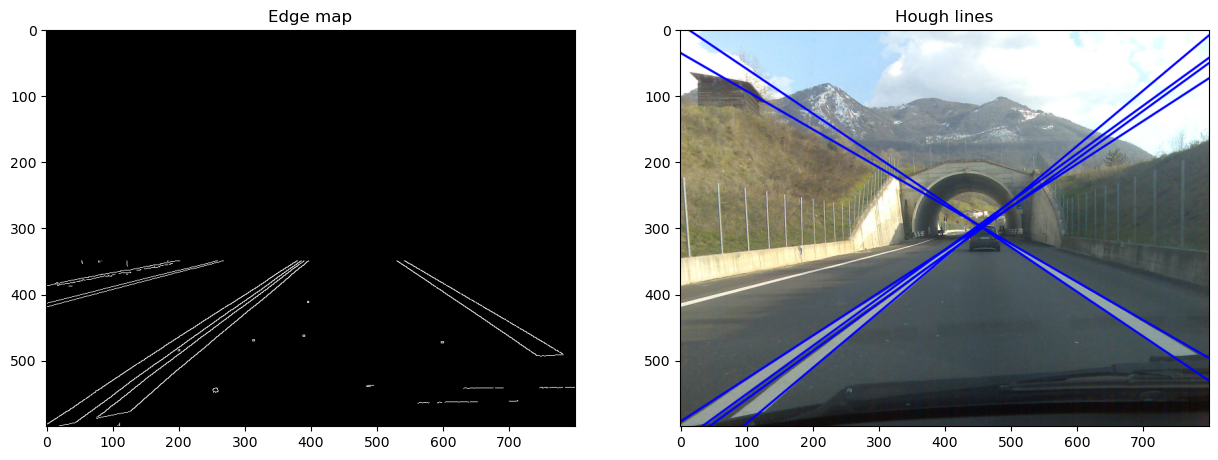

In [114]:
# Again, let's plot the resulting filtered lines
result = np.copy(img)
    
for line in kmeans.cluster_centers_:
    rho, theta = line

    a = math.cos(theta)
    b = math.sin(theta)
    
    x0 = a * rho
    y0 = b * rho
    
    pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
    pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
    
    cv2.line(result, pt1, pt2, (0, 0, 255), 2, cv2.LINE_AA)

plt.subplot(121), plt.imshow(edges, cmap='gray'), plt.title('Edge map')
plt.subplot(122), plt.imshow(result, cmap='gray'), plt.title('Hough lines')